# Assignment 2



# Q2.1

Here, I implement the Crank-Nicolson method as the crank function and I am using code from the model solutions to assignment 1 to plot the graph and the display the table of errors

In [1]:
import numpy as np
from numpy.linalg import norm
from numpy import sin,cos,pi,array, exp, zeros, sqrt
from IPython.display import display
from matplotlib import pyplot as plt
import pandas as pd

from Q2General import *

def crank(f, Df, t0, y0, h):
    f0 = f(t0,y0)
    F =  lambda delta: delta-f(t0+h,y0+(h/2)*(f0 + delta))
    DF = lambda delta: np.eye(len(y0))-(h/2)*Df(t0+h,y0+(h/2)*(f0 + delta))
    delta,_ = newton(F,DF,f(t0+h,y0),h*h*1e-5,1000)
    return y0 + (h/2)*(f0 + delta)

Y = lambda t: array([2*exp(t)/(2*exp(t)-1),
(-2*exp(t))/(4*exp(2*t)-4*exp(t)+1)])

def f(t,y):
    return array([y[1], y[1]*(1-2*y[0])])

def Df(t,y):
    return array([[0,1],[2*y[1],1-2*y[0]]])

def experiment(stepper, f, Df, Y, T, M, N0):
    herr = np.zeros( [M,2] )
    for m in range(M):
        N = N0*2**m
        t,y = evolve( stepper, f,Df, 0,Y(0),T, N)
        herr[m] = [T/N, 0]
        for tn,yn in zip(t,y):
            herr[m][1] = max(herr[m][1], norm(yn-Y(tn)) )
    eoc = computeEocs( herr )
    eoc = np.hstack( [ [np.nan],eoc ] )
    res = np.hstack( [herr, np.atleast_2d(eoc).T] )
    return res

def compareErrors(results):
    # columns of table
    simul = list(results.keys())
    columns=['h'] + [s for n in simul for s in [f'{n}-error', f'{n}-eoc']]
    # values in tablea
    keys   = {columns[0]: results[simul[0]][:,0]} # all results are assumed to use the same sequence of h
    styles = {columns[0]: '{:.4e}'}
    for i, k in enumerate(simul):
        keys[columns[2*i+1]]   = results[k][:,1] # errors
        styles[columns[2*i+1]] = '{:.6e}'
        keys[columns[2*i+2]]   = results[k][:,2] # eocs
        styles[columns[2*i+2]] = '{:.3f}'

    # generate table
    table = pd.DataFrame(keys, index=range(results[simul[0]].shape[0]), # all results must have the same shape
            columns=columns)

    # format floating points for each column for jupyter output (does not work in pdf)
    display( table.style.format(styles) )

    for i,k in enumerate(simul):
        plt.loglog(results[k][:,0],results[k][:,1],marker='o',label=k)
    plt.legend()
    plt.grid(True)
    plt.xlabel("step size h")
    plt.ylabel("Maximum error over time")
    #plt.savefig("Q2_compareErr.pdf", format="pdf", bbox_inches="tight") # output to pdf for inclusing in tex document
    plt.show()

,h,FE-error,FE-eoc,BE-error,BE-eoc,Q11-error,Q11-eoc,CN-error,CN-eoc
0,4.0000e-01,1.197520e+00,nan,1.169567e+00,nan,2.336009e-01,nan,1.853745e-01,nan
1,2.0000e-01,3.849013e-01,1.637,1.949449e-01,2.585,5.724377e-02,2.029,4.250296e-02,2.125
2,1.0000e-01,1.424462e-01,1.434,1.058020e-01,0.882,1.252991e-02,2.192,1.013312e-02,2.068
3,5.0000e-02,6.525497e-02,1.126,5.635233e-02,0.909,2.894328e-03,2.114,2.522717e-03,2.006
4,2.5000e-02,3.135656e-02,1.057,2.914622e-02,0.951,6.889803e-04,2.071,6.287613e-04,2.004
5,1.2500e-02,1.538350e-02,1.027,1.483127e-02,0.975,1.680073e-04,2.036,1.571657e-04,2.000
6,6.2500e-03,7.620535e-03,1.013,7.482302e-03,0.987,4.148271e-05,2.018,3.928423e-05,2.000
7,3.1250e-03,3.792678e-03,1.007,3.758094e-03,0.993,1.030578e-05,2.009,9.820607e-06,2.000
8,1.5625e-03,1.891968e-03,1.003,1.883324e-03,0.997,2.568356e-06,2.005,2.455153e-06,2.000
9,7.8125e-04,9.448989e-04,1.002,9.427381e-04,0.998,6.410798e-07,2.002,6.137863e-07,2.000


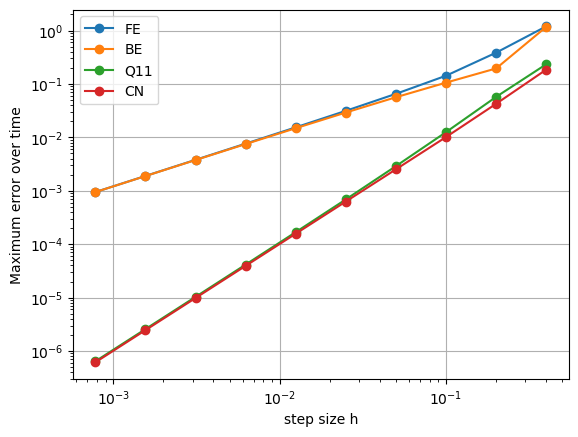

In [2]:
T = 10
M = 10
N0 = 25

params = (f,Df,Y,T,M,N0)

resFE = experiment(forwardEuler,*params)
resQ11 = experiment(Q11,*params)
resCN = experiment(crank,*params)
resBE = experiment(backwardEuler,*params)


compareErrors({"FE":resFE,"BE":resBE,"Q11":resQ11,"CN":resCN})

# Discussion

The graph displays the behaviour we expect, namely that the two second order methods, Q11 and Crank-Nicolson, which converge as $h^2$, have maximum errors that are approximately $h^2$ for each value of $h$ (e.g for $h \approx 10^{-3}$, the error is approximately $10^{-6}$). We see similar behaviour for the first order methods, where the maximum error is approximately $h$ for each $h$ value.

# Q2.2

First, we consider $r=2$, where $$H(x,p) = \frac{1}{2}p^2 + \frac{1}{2}x^2$$
So , we have $${x}' = \partial _{p} H(x,p) = p$$

$${p}' = -\partial _{p} H(x,p) = -x$$
Thus, we have $$f(t,y) = (p,-x)$$ and 
$$Df(t,y) = Df = \begin{bmatrix}
0 & 1\\ 
-1 & 0
\end{bmatrix}$$ 

The exact solution is given by $Y(t) = (\sin(t),\cos(t))$

Now the implementation:

,h,Q11-error,Q11-eoc,BE-error,BE-eoc,CN-error,CN-eoc
0,2.6667e-01,4.920079e-01,nan,9.964574e-01,nan,2.340031e-01,nan
1,1.3333e-01,1.191125e-01,2.046,9.309638e-01,0.098,5.909313e-02,1.985
2,6.6667e-02,2.964800e-02,2.006,7.362502e-01,0.339,1.480481e-02,1.997
3,3.3333e-02,7.407921e-03,2.001,4.865085e-01,0.598,3.703084e-03,1.999
4,1.6667e-02,1.851863e-03,2.000,2.834529e-01,0.779,9.258873e-04,2.000
5,8.3333e-03,4.629630e-04,2.000,1.535157e-01,0.885,2.314791e-04,2.000
6,4.1667e-03,1.157407e-04,2.000,7.995523e-02,0.941,5.787022e-05,2.000
7,2.0833e-03,2.893518e-05,2.000,4.081050e-02,0.970,1.446759e-05,2.000
8,1.0417e-03,7.233812e-06,2.000,2.061781e-02,0.985,3.616882e-06,2.000
9,5.2083e-04,1.808475e-06,2.000,1.036260e-02,0.993,9.041984e-07,2.000


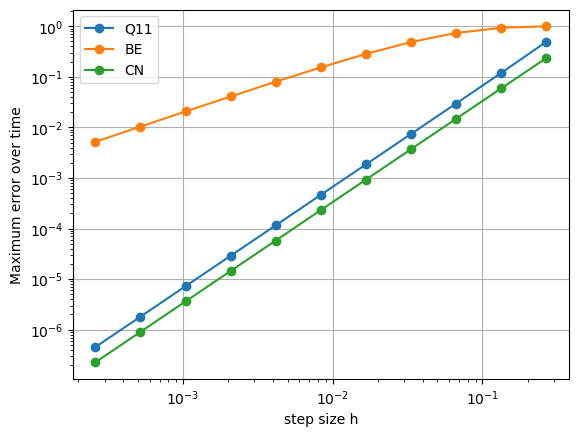

In [3]:
def Y2(t):
    return array([sin(t),cos(t)])

def f2(t,y):
    return array([y[1],-y[0]])

def Df2(t,y):
    return array([[0,1],[-1,0]])

T = 40
M = 11
N0 = 150

params = (f2,Df2,Y2,T,M,N0)

resQ11 = experiment(Q11,*params)
resCN = experiment(crank,*params)
resBE = experiment(backwardEuler,*params)

compareErrors({"Q11":resQ11,"BE":resBE,"CN":resCN})

# Phase diagrams, $r = 2$

In [4]:
def phasePlotter(method, f, Df,r):
    plt.figure()
    plt.xlabel("Position x")
    plt.ylabel("Momentum p")
    plt.title("Phase diagram for "+method.__name__+" method, r = "+str(r))
    for i in range(2):
        yn = evolve(method,f,Df,0,array([0,1]),T,150*(i+1))[1]
        plt.plot(yn.T[0], yn.T[1], label = "i="+str(i),)
    plt.xlim([-1.5,1.5])
    plt.ylim([-1.5,1.5])
    plt.legend()

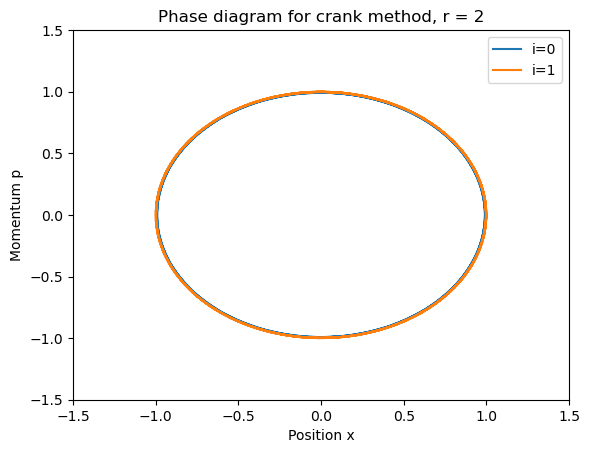

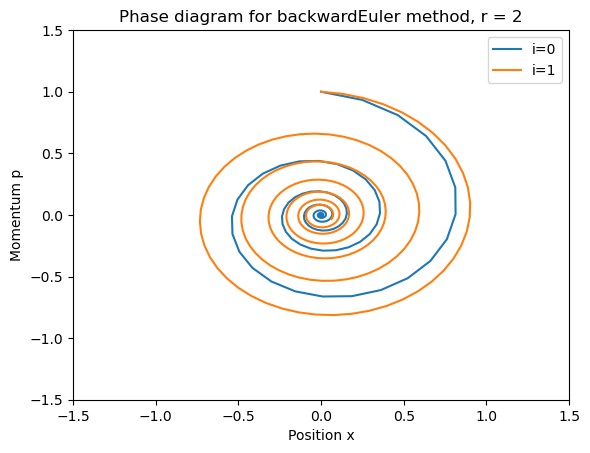

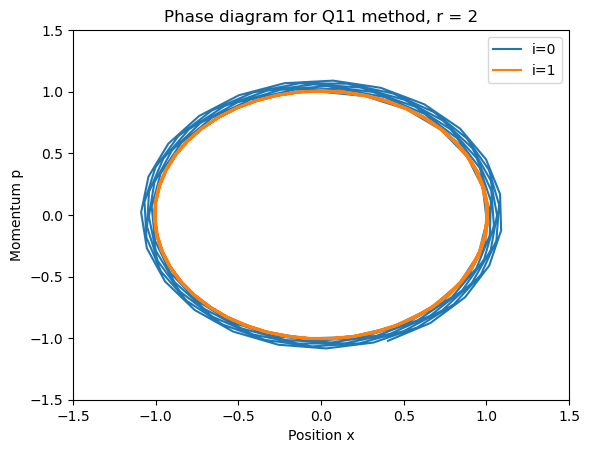

In [5]:
phasePlotter(crank,f2,Df2,2)
phasePlotter(backwardEuler,f2,Df2,2)
phasePlotter(Q11, f2, Df2,2)

plt.show()

Now, we consider $r = 4$. The Hamiltonian is $$H(x,p) = \frac{1}{2}p^2 +\frac{k^2+1}{2}x^2 - \frac{k^2}{2}x^4$$
So, we have the following system of ODEs $${x}' = \partial _{p} H(x,p) = p$$

$${p}' = -\partial _{p} H(x,p) = 2k^2x^3 - (k^2+1)x$$

This gives $$f(t,y) = \begin{pmatrix}
p
\\ 2k^2x^3 - (k^2+1)x
\end{pmatrix}$$

and $$Df(t,y) = \begin{bmatrix}
0 & 1\\ 
6k^2x^2-(k^2+1) & 0
\end{bmatrix}$$

We are given the exact solution, so now we implement:

C:\Users\Ed\AppData\Local\Temp\ipykernel_7400\2658102305.py:11: RuntimeWarning: overflow encountered in double_scalars
  return array([p, 2*(k**2)*(x**3) - (k**2 + 1)*x])
C:\Users\Ed\AppData\Local\Temp\ipykernel_7400\2658102305.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return array([p, 2*(k**2)*(x**3) - (k**2 + 1)*x])
C:\Users\Ed\Documents\MA261\assignment2\Q2General.py:20: RuntimeWarning: divide by zero encountered in log
  eocs[i] = np.log(herr[i+1,1]/herr[i,1] ) /\


,h,Q11-error,Q11-eoc,BE-error,BE-eoc,CN-error,CN-eoc
0,2.6667e-01,inf,nan,1.245470e+00,nan,1.671342e+00,nan
1,1.3333e-01,1.586126e+00,inf,1.391192e+00,-0.160,5.155151e-01,1.697
2,6.6667e-02,3.242903e-01,2.290,1.651777e+00,-0.248,1.270697e-01,2.020
3,3.3333e-02,5.871152e-02,2.466,1.777689e+00,-0.106,3.153798e-02,2.010
4,1.6667e-02,1.201850e-02,2.288,1.797906e+00,-0.016,7.868297e-03,2.003
5,8.3333e-03,2.677790e-03,2.166,1.865162e+00,-0.053,1.966044e-03,2.001
6,4.1667e-03,6.288112e-04,2.090,1.940380e+00,-0.057,4.914425e-04,2.000
7,2.0833e-03,1.521329e-04,2.047,1.535497e+00,0.338,1.228579e-04,2.000
8,1.0417e-03,3.739998e-05,2.024,1.013199e+00,0.600,3.071428e-05,2.000
9,5.2083e-04,9.270844e-06,2.012,5.788232e-01,0.808,7.678537e-06,2.000


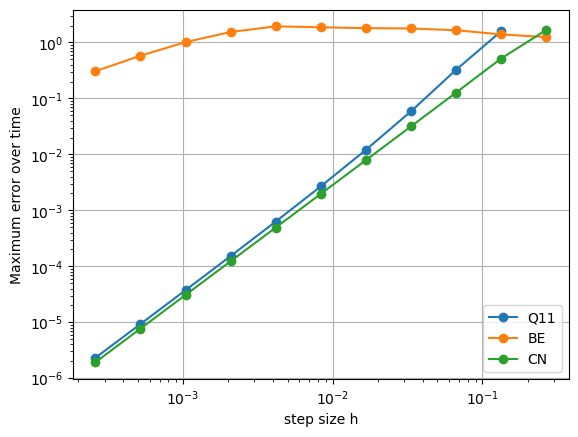

In [6]:
k  = 0.8

from scipy . special import ellipj
def Y4(t):
    sn , cn , dn , _ = ellipj (t, k*k)
    return array ([ sn , cn * dn ]) # (x(t) ,p(t))

def f4(t,y):
    x = y[0]
    p = y[1]
    return array([p, 2*(k**2)*(x**3) - (k**2 + 1)*x])

def Df4(t,y):
    x = y[0]
    p = y[1]
    return array([[0,1],[6*(k**2)*(x**2) - (k**2 +1), 0]])


params = (f4,Df4,Y4,T,M,N0)
resQ11 = experiment(Q11,*params)
resCN = experiment(crank,*params)
resBE = experiment(backwardEuler,*params)

compareErrors({"Q11":resQ11,"BE":resBE,"CN":resCN})

The diagram above suggests that the Backwards Euler method is not suitable for this ODE system, as the error stays relatively constant as $h$ decreases, and the EOCs approach 1 very slowly. We also see that for the largest value of $h$, the Q11 method gives inf, which implies that the method does not converge for values of $h>\frac{40}{150}$

# Phase diagrams, $r=4$

C:\Users\Ed\AppData\Local\Temp\ipykernel_7400\2658102305.py:11: RuntimeWarning: overflow encountered in double_scalars
  return array([p, 2*(k**2)*(x**3) - (k**2 + 1)*x])
C:\Users\Ed\AppData\Local\Temp\ipykernel_7400\2658102305.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return array([p, 2*(k**2)*(x**3) - (k**2 + 1)*x])


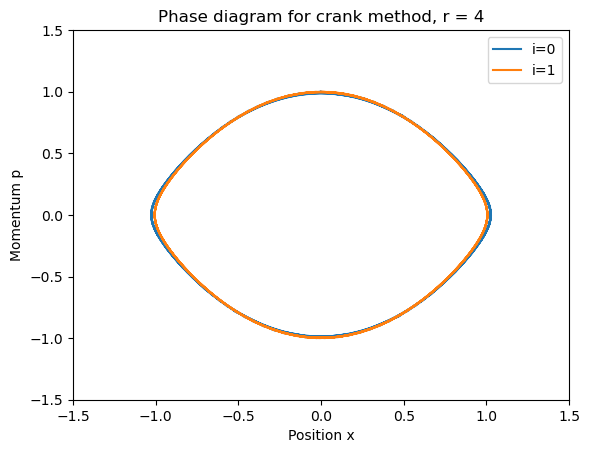

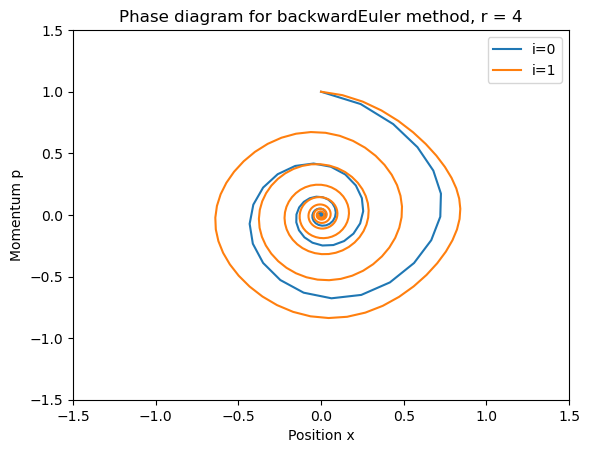

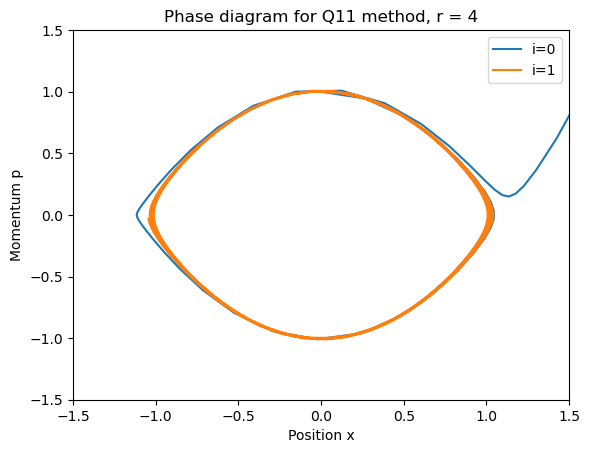

In [7]:
phasePlotter(crank,f4,Df4,4)
phasePlotter(backwardEuler,f4,Df4,4)
phasePlotter(Q11, f4, Df4,4)

plt.show()

# Q2.3

Here is my implementation of the semi-implicit Euler method and a function to compute the relative error in the Hamiltionan.

In [8]:
def SIE(f,Df,t0,H0,h):
    x0, p0 = H0
    xn = x0 + h*f(t0,H0)[0]
    pn = p0 + h*f(t0,array([xn,p0]))[1]
    return array([xn,pn])

def hamError(stepper, f, Df,y0,T, M, N0):
    herr = np.zeros( [M,2] )
    H0 = H(y0)
    for m in range(M):
        N = N0*2**m
        t,y = evolve( stepper, f,Df, 0,y0,T, N)
        herr[m] = [T/N, 0]
        for i in range(len(y)):
            herr[m][1] = max(herr[m][1], np.abs(H(y[i])-H0)/np.abs(H0))
    return herr

Now we repeat the experiments from Q2.1, starting off with the $r=2$ case

,h,Q11-error,Q11-eoc,BE-error,BE-eoc,CN-error,CN-eoc,SIE-error,SIE-eoc
0,2.6667e-01,4.920079e-01,nan,9.964574e-01,nan,2.340031e-01,nan,2.516098e-01,nan
1,1.3333e-01,1.191125e-01,2.046,9.309638e-01,0.098,5.909313e-02,1.985,9.588617e-02,1.392
2,6.6667e-02,2.964800e-02,2.006,7.362502e-01,0.339,1.480481e-02,1.997,4.063059e-02,1.239
3,3.3333e-02,7.407921e-03,2.001,4.865085e-01,0.598,3.703084e-03,1.999,1.848764e-02,1.136
4,1.6667e-02,1.851863e-03,2.000,2.834529e-01,0.779,9.258873e-04,2.000,8.788152e-03,1.073
5,8.3333e-03,4.629630e-04,2.000,1.535157e-01,0.885,2.314791e-04,2.000,4.280311e-03,1.038
6,4.1667e-03,1.157407e-04,2.000,7.995523e-02,0.941,5.787022e-05,2.000,2.111746e-03,1.019
7,2.0833e-03,2.893518e-05,2.000,4.081050e-02,0.970,1.446759e-05,2.000,1.048769e-03,1.010
8,1.0417e-03,7.233812e-06,2.000,2.061781e-02,0.985,3.616882e-06,2.000,5.226089e-04,1.005
9,5.2083e-04,1.808475e-06,2.000,1.036260e-02,0.993,9.041984e-07,2.000,2.608606e-04,1.002


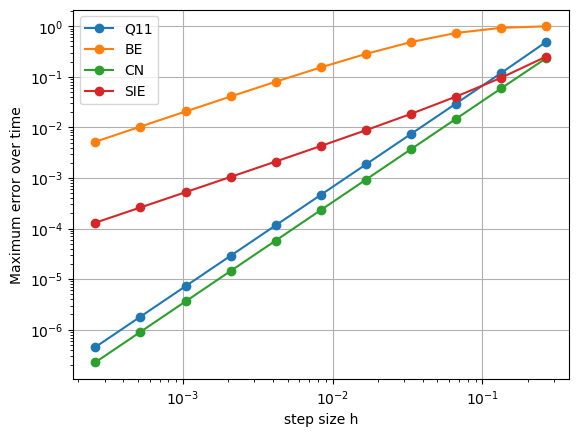

In [39]:
params = (f2,Df2,Y2,40,11,150)

resQ11 = experiment(Q11,*params)
resCN = experiment(crank,*params)
resBE = experiment(backwardEuler,*params)
resSIE = experiment(SIE,*params)

compareErrors({"Q11":resQ11,"BE":resBE,"CN":resCN,"SIE":resSIE})

Now lets look at the relative errors for the Hamiltonian. Here, I have slightly modified the compareErrors function to show the relative errors

In [10]:
 def compareErrors2(results):
    # columns of table
    simul = list(results.keys())
    columns=['h'] + [s for n in simul for s in [f'{n}-max error', f'{n}-eoc',f'{n}-relative error']]
    # values in tablea
    keys   = {columns[0]: results[simul[0]][:,0]} # all results are assumed to use the same sequence of h
    styles = {columns[0]: '{:.4e}'}
    for i, k in enumerate(simul):
        keys[columns[3*i+1]]   = results[k][:,1] # errors
        styles[columns[3*i+1]] = '{:.6e}'
        keys[columns[3*i+2]]   = results[k][:,2] # eocs
        styles[columns[3*i+2]] = '{:.3f}'
        keys[columns[3*i+3]]   = results[k][:,3] # relative errors
        styles[columns[3*i+3]] = '{:.6e}'

    # generate table
    table = pd.DataFrame(keys, index=range(results[simul[0]].shape[0]), # all results must have the same shape
            columns=columns)
    #print(table)

    # format floating points for each column for jupyter output (does not work in pdf)
    display( table.style.format(styles) )

In [40]:
H = lambda y: 1/2*y[0]**2+1/2*y[1]**2

params = (f2,Df2,array([0,1]),40,11,150)

resSIE_2 = np.c_[resSIE,hamError(SIE,*params).T[1]]
resCN_2 = np.c_[resCN,hamError(crank,*params).T[1]]
resBE_2 = np.c_[resBE,hamError(backwardEuler,*params).T[1]]
resQ11_2 = np.c_[resQ11,hamError(Q11,*params).T[1]]

compareErrors2({"SIE":resSIE_2,"Q11":resQ11_2,"CN":resCN_2,"BE":resBE_2})  

,h,SIE-max error,SIE-eoc,SIE-relative error,Q11-max error,Q11-eoc,Q11-relative error,CN-max error,CN-eoc,CN-relative error,BE-max error,BE-eoc,BE-relative error
0,2.6667e-01,2.516098e-01,nan,1.538396e-01,4.920079e-01,nan,2.086570e-01,2.340031e-01,nan,1.221245e-15,9.964574e-01,nan,9.999665e-01
1,1.3333e-01,9.588617e-02,1.392,7.142441e-02,1.191125e-01,2.046,2.398591e-02,5.909313e-02,1.985,1.332268e-15,9.309638e-01,0.098,9.949405e-01
2,6.6667e-02,4.063059e-02,1.239,3.448274e-02,2.964800e-02,2.006,2.967350e-03,1.480481e-02,1.997,1.332268e-15,7.362502e-01,0.339,9.301048e-01
3,3.3333e-02,1.848764e-02,1.136,1.694891e-02,7.407921e-03,2.001,3.704389e-04,3.703084e-03,1.999,2.775558e-15,4.865085e-01,0.598,7.362077e-01
4,1.6667e-02,8.788152e-03,1.073,8.403348e-03,1.851863e-03,2.000,4.629737e-05,9.258873e-04,2.000,2.664535e-15,2.834529e-01,0.779,4.865353e-01
5,8.3333e-03,4.280311e-03,1.038,4.184016e-03,4.629630e-04,2.000,5.787054e-06,2.314791e-04,2.000,2.442491e-15,1.535157e-01,0.885,2.834604e-01
6,4.1667e-03,2.111746e-03,1.019,2.087683e-03,1.157407e-04,2.000,7.233799e-07,5.787022e-05,2.000,4.884981e-15,7.995523e-02,0.941,1.535171e-01
7,2.0833e-03,1.048769e-03,1.010,1.042752e-03,2.893518e-05,2.000,9.042246e-08,1.446759e-05,2.000,7.105427e-15,4.081050e-02,0.970,7.995542e-02
8,1.0417e-03,5.226089e-04,1.005,5.211047e-04,7.233812e-06,2.000,1.130282e-08,3.616882e-06,2.000,9.992007e-15,2.061781e-02,0.985,4.081052e-02
9,5.2083e-04,2.608606e-04,1.002,2.604845e-04,1.808475e-06,2.000,1.412851e-09,9.041984e-07,2.000,1.287859e-14,1.036260e-02,0.993,2.061782e-02


The relative errors for the Crank-Nicolson method are extremely small, which implies that it is the best method to use for this Hamiltionian system





Now, we consider the $r=4$ case:

C:\Users\Ed\AppData\Local\Temp\ipykernel_7400\2658102305.py:11: RuntimeWarning: overflow encountered in double_scalars
  return array([p, 2*(k**2)*(x**3) - (k**2 + 1)*x])
C:\Users\Ed\AppData\Local\Temp\ipykernel_7400\2658102305.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return array([p, 2*(k**2)*(x**3) - (k**2 + 1)*x])
C:\Users\Ed\Documents\MA261\assignment2\Q2General.py:20: RuntimeWarning: divide by zero encountered in log
  eocs[i] = np.log(herr[i+1,1]/herr[i,1] ) /\


,h,Q11-error,Q11-eoc,BE-error,BE-eoc,CN-error,CN-eoc,SIE-error,SIE-eoc
0,2.6667e-01,inf,nan,1.245470e+00,nan,1.671342e+00,nan,1.806380e+00,nan
1,1.3333e-01,1.586126e+00,inf,1.391192e+00,-0.160,5.155151e-01,1.697,5.503766e-01,1.715
2,6.6667e-02,3.242903e-01,2.290,1.651777e+00,-0.248,1.270697e-01,2.020,1.347051e-01,2.031
3,3.3333e-02,5.871152e-02,2.466,1.777689e+00,-0.106,3.153798e-02,2.010,3.330688e-02,2.016
4,1.6667e-02,1.201850e-02,2.288,1.797906e+00,-0.016,7.868297e-03,2.003,8.303854e-03,2.004
5,8.3333e-03,2.677790e-03,2.166,1.865162e+00,-0.053,1.966044e-03,2.001,2.971172e-03,1.483
6,4.1667e-03,6.288112e-04,2.090,1.940380e+00,-0.057,4.914425e-04,2.000,1.487067e-03,0.999
7,2.0833e-03,1.521329e-04,2.047,1.535497e+00,0.338,1.228579e-04,2.000,7.439090e-04,0.999
8,1.0417e-03,3.739998e-05,2.024,1.013199e+00,0.600,3.071428e-05,2.000,3.720478e-04,1.000
9,5.2083e-04,9.270844e-06,2.012,5.788232e-01,0.808,7.678537e-06,2.000,1.860472e-04,1.000


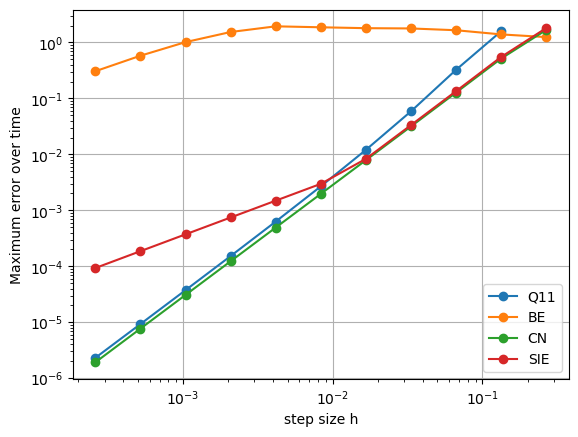

In [41]:
params = (f4,Df4,Y4,40,11,150)

resQ11 = experiment(Q11,*params)
resCN = experiment(crank,*params)
resBE = experiment(backwardEuler,*params)
resSIE = experiment(SIE,*params)

compareErrors({"Q11":resQ11,"BE":resBE,"CN":resCN,"SIE":resSIE})

We see that the semi-implict Euler method has small errors for larger values of $h$, but as $h$ decreases, it falls behind the second order methods

In [42]:
k = 0.8
H = lambda y: 1/2*y[1]**2 + (k**2+1)/2 *y[0]**2 - ((k**2)/2)*y[0]**4 

params = (f4,Df4,array([0,1]),40,11,150)

resSIE_4 = np.c_[resSIE,hamError(SIE,*params).T[1]]
resCN_4 = np.c_[resCN,hamError(crank,*params).T[1]]
resBE_4 = np.c_[resBE,hamError(backwardEuler,*params).T[1]]
resQ11_4 = np.c_[resQ11,hamError(Q11,*params).T[1]]

compareErrors2({"SIE":resSIE_4,"Q11":resQ11_4,"CN":resCN_4,"BE":resBE_4})  

C:\Users\Ed\AppData\Local\Temp\ipykernel_7400\2658102305.py:11: RuntimeWarning: overflow encountered in double_scalars
  return array([p, 2*(k**2)*(x**3) - (k**2 + 1)*x])
C:\Users\Ed\AppData\Local\Temp\ipykernel_7400\2658102305.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return array([p, 2*(k**2)*(x**3) - (k**2 + 1)*x])
C:\Users\Ed\AppData\Local\Temp\ipykernel_7400\1748104396.py:2: RuntimeWarning: overflow encountered in double_scalars
  H = lambda y: 1/2*y[1]**2 + (k**2+1)/2 *y[0]**2 - ((k**2)/2)*y[0]**4
C:\Users\Ed\AppData\Local\Temp\ipykernel_7400\1748104396.py:2: RuntimeWarning: invalid value encountered in double_scalars
  H = lambda y: 1/2*y[1]**2 + (k**2+1)/2 *y[0]**2 - ((k**2)/2)*y[0]**4


,h,SIE-max error,SIE-eoc,SIE-relative error,Q11-max error,Q11-eoc,Q11-relative error,CN-max error,CN-eoc,CN-relative error,BE-max error,BE-eoc,BE-relative error
0,2.6667e-01,1.806380e+00,nan,1.682538e-01,inf,nan,4.756569e+230,1.671342e+00,nan,1.839231e-02,1.245470e+00,nan,9.999999e-01
1,1.3333e-01,5.503766e-01,1.715,7.642963e-02,1.586126e+00,inf,2.810778e-02,5.155151e-01,1.697,4.503940e-03,1.391192e+00,-0.160,9.996204e-01
2,6.6667e-02,1.347051e-01,2.031,3.651316e-02,3.242903e-01,2.290,3.994322e-03,1.270697e-01,2.020,1.120586e-03,1.651777e+00,-0.248,9.724813e-01
3,3.3333e-02,3.330688e-02,2.016,1.785257e-02,5.871152e-02,2.466,6.378451e-04,3.153798e-02,2.010,2.798134e-04,1.777689e+00,-0.106,7.776251e-01
4,1.6667e-02,8.303854e-03,2.004,8.827914e-03,1.201850e-02,2.288,1.146536e-04,7.868297e-03,2.003,6.993266e-05,1.797906e+00,-0.016,4.535850e-01
5,8.3333e-03,2.971172e-03,1.483,4.389656e-03,2.677790e-03,2.166,2.307004e-05,1.966044e-03,2.001,1.748182e-05,1.865162e+00,-0.053,2.214242e-01
6,4.1667e-03,1.487067e-03,0.999,2.188790e-03,6.288112e-04,2.090,5.068741e-06,4.914425e-04,2.000,4.370346e-06,1.940380e+00,-0.057,1.047656e-01
7,2.0833e-03,7.439090e-04,0.999,1.092890e-03,1.521329e-04,2.047,1.179870e-06,1.228579e-04,2.000,1.092591e-06,1.535497e+00,0.338,4.970915e-02
8,1.0417e-03,3.720478e-04,1.000,5.460695e-04,3.739998e-05,2.024,2.840561e-07,3.071428e-05,2.000,2.731481e-07,1.013199e+00,0.600,2.447618e-02
9,5.2083e-04,1.860472e-04,1.000,2.729409e-04,9.270844e-06,2.012,6.965035e-08,7.678537e-06,2.000,6.828704e-08,5.788232e-01,0.808,1.208902e-02


# Discussion

It appears that the semi-implicit Euler(SIE) method is $O(h)$. Compared to the other methods, it is better than the backward Euler but worse than the Crank-Nicolson and Q11 methods in terms of the errors it gives. However, i would still say the Q11 method is the best because it is computationally light, as it doesn't require the newton funcction, and gives very similar errors to the Crank Nicolson method for both cases of $r$.




# Q2.4

$r=2$ case;

In [32]:
y = lambda t: array([sin(t), cos(t)])

def newton2 (F, DF, x0, eps, K):
    x=x0
    k=0
    while k < K:
        x -= F(x)/DF(x)
        if norm (F(x)) < eps:
            break
        k += 1
    return x, k

V = lambda x: ((k**2 + 1)*x**2)/2 - ((k**2) *x**2)/2
DV = lambda x: ((k**2+1) *x) - 2*((k**2)*x)/2

In [33]:
def FIE (f, Df, t, y, h):
    x0 = y[0]
    p0 = y[1]
    F = lambda delta: delta - p0+ (V(x0+h*delta) - V(x0))/2*delta
    DF = lambda delta: 1+ (h*delta*DV(x0+ h*delta) - V(x0+ h*delta) + V(x0))/(2*(delta**2))
    x, k = newton2 (F, DF, p0, h*h*1e-5, 1000)
    x1 = (x0+ h*x)
    p1= (p0 - h*(V(x1) - V(x0))/(x1-x0))
    return array([x1, p1])


In [45]:
H = lambda y: 1/2*y[0]**2+1/2*y[1]**2

params = (40,11,150)

resFIE = experiment(FIE,f2,Df2,Y2,*params)
resFIE_2 = np.c_[resFIE,hamError(FIE,f2,Df2,array([0,1]),*params).T[1]]


compareErrors2({"SIE":resSIE_2,"Q11":resQ11_2,"CN":resCN_2,"BE":resBE_2,"FIE":resFIE_2}) 

,h,SIE-max error,SIE-eoc,SIE-relative error,Q11-max error,Q11-eoc,Q11-relative error,CN-max error,CN-eoc,CN-relative error,BE-max error,BE-eoc,BE-relative error,FIE-max error,FIE-eoc,FIE-relative error
0,2.6667e-01,2.516098e-01,nan,1.538396e-01,4.920079e-01,nan,2.086570e-01,2.340031e-01,nan,1.221245e-15,9.964574e-01,nan,9.999665e-01,1.023944e+00,nan,3.054118e+00
1,1.3333e-01,9.588617e-02,1.392,7.142441e-02,1.191125e-01,2.046,2.398591e-02,5.909313e-02,1.985,1.332268e-15,9.309638e-01,0.098,9.949405e-01,8.540995e-01,0.262,2.433475e+00
2,6.6667e-02,4.063059e-02,1.239,3.448274e-02,2.964800e-02,2.006,2.967350e-03,1.480481e-02,1.997,1.332268e-15,7.362502e-01,0.339,9.301048e-01,5.080181e-01,0.750,1.273172e+00
3,3.3333e-02,1.848764e-02,1.136,1.694891e-02,7.407921e-03,2.001,3.704389e-04,3.703084e-03,1.999,2.775558e-15,4.865085e-01,0.598,7.362077e-01,2.602904e-01,0.965,5.882518e-01
4,1.6667e-02,8.788152e-03,1.073,8.403348e-03,1.851863e-03,2.000,4.629737e-05,9.258873e-04,2.000,2.664535e-15,2.834529e-01,0.779,4.865353e-01,1.293597e-01,1.009,2.754494e-01
5,8.3333e-03,4.280311e-03,1.038,4.184016e-03,4.629630e-04,2.000,5.787054e-06,2.314791e-04,2.000,2.442491e-15,1.535157e-01,0.885,2.834604e-01,6.420607e-02,1.011,1.325346e-01
6,4.1667e-03,2.111746e-03,1.019,2.087683e-03,1.157407e-04,2.000,7.233799e-07,5.787022e-05,2.000,4.884981e-15,7.995523e-02,0.941,1.535171e-01,3.195267e-02,1.007,6.492611e-02
7,2.0833e-03,1.048769e-03,1.010,1.042752e-03,2.893518e-05,2.000,9.042246e-08,1.446759e-05,2.000,7.105427e-15,4.081050e-02,0.970,7.995542e-02,1.593497e-02,1.004,3.212363e-02
8,1.0417e-03,5.226089e-04,1.005,5.211047e-04,7.233812e-06,2.000,1.130282e-08,3.616882e-06,2.000,9.992007e-15,2.061781e-02,0.985,4.081052e-02,7.956685e-03,1.002,1.597652e-02
9,5.2083e-04,2.608606e-04,1.002,2.604845e-04,1.808475e-06,2.000,1.412851e-09,9.041984e-07,2.000,1.287859e-14,1.036260e-02,0.993,2.061782e-02,3.975586e-03,1.001,7.966888e-03


It seems that the fully implict Euler method is $O(h)$, but overall still isn't as good as the Q11 method, especially given that it is very computationally complex